# Final Project Chaos
#### Using machine learning to replicate chaotic attractors and calculate Lyapunov exponents from data

Clint van Hoesel 1012071

#### Notes
**(Todo)**:
 - Understand and program Echo State Network
 - Choose Tikhonov regularized regression procedure or backprop
 - Implement dynamical systems (inots, outputs, generation) (Lorenz and KS)
 - Find Lyupanov expinents


**(Ideas)**:
 - Compare to LSTM/GRU/RNN
 - Why use RNN in these systems at all
 - Lyupanov exponent between real data and generated data
 - umap or PCA
 - Fourier Transform KS

## Data Generation

### Lorenz
DONE

In [ ]:
# DATA GENERATION Lorenz sytem
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.integrate import odeint, solve_ivp
import numba as nb

r = 28.0
sigma = 10.0
b = 8.0 / 3.0

t_begin= 0.0
t_end = 100.0
t_end_test = 100.0
dt = 0.01

def f(state, t):
    x, y, z = state  # unpack the state vector
    return np.array([sigma * (y - x), x * (r - z) - y, x * y - b * z])  # derivatives

def df_dx(state, t):
    x, y, z = state  # unpack the state vector
    df_dx_array = np.zeros((3,3))
    df_dx_array[0,:] = [-sigma,sigma,0]
    df_dx_array[1,:] = [r-z,-1,-x]
    df_dx_array[2,:] = [y,x,-b]
    return df_dx_array

state0 = [-4.90269086, -3.74390651, 24.69081555]
t = np.arange(t_begin, t_end, dt)
t_test = np.arange(t_begin, t_end_test, dt)

# states = odeint(f, state0, t)
states = solve_ivp(lambda t,y: f(y,t),(t_begin,t_end),state0,t_eval=t).y.T

print(states.shape)
inputs = states[:-1,:]
outputs = states[1:,:]
                 
# states_test = odeint(f, states[-1,:], t_test)
states_test = solve_ivp(lambda t,y: f(y,t),(t_begin,t_end_test),states[-1,:],t_eval=t_test).y.T

### Kuramoto-Sivashinsky
NOT DONE

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm

# Adapted from: https://github.com/jswhit/pyks/blob/master/KS.py
class KS(object):
    #
    # Solution of 1-d Kuramoto-Sivashinsky equation, the simplest
    # PDE that exhibits spatio-temporal chaos
    # (https://www.encyclopediaofmath.org/index.php/Kuramoto-Sivashinsky_equation).
    #
    # u_t + u*u_x + u_xx + diffusion*u_xxxx = 0, periodic BCs on [0,2*pi*L].
    # time step dt with N fourier collocation points.
    # energy enters the system at long wavelengths via u_xx,
    # (an unstable diffusion term),
    # cascades to short wavelengths due to the nonlinearity u*u_x, and
    # dissipates via diffusion*u_xxxx.
    #
    def __init__(self,L=16,N=128,dt=0.5,diffusion=1.0,members=1,rs=None):
        self.L = L; self.n = N; self.members = members; self.dt = dt
        self.diffusion = diffusion
        kk = N*np.fft.fftfreq(N)[0:int((N/2)+1)]  # wave numbers
        self.wavenums = kk
        k  = kk.astype(np.float)/L
        self.ik    = 1j*k                   # spectral derivative operator
        self.lin   = k**2 - diffusion*k**4  # Fourier multipliers for linear term
        # random noise initial condition.
        if rs is None:
            rs = np.random.RandomState()
        x = 0.1*rs.standard_normal(size=(members,N))
        # remove zonal mean from initial condition.
        self.x = x - x.mean()
        # spectral space variable
        self.xspec = np.fft.rfft(self.x,axis=-1)
    def nlterm(self,xspec):
        # compute tendency from nonlinear term.
        x = np.fft.irfft(xspec,axis=-1)
        return -0.5*self.ik*np.fft.rfft(x**2,axis=-1) # Should add the mu term, but that is not nice in Fourier space
    def advance(self):
        # semi-implicit third-order runge kutta update.
        # ref: http://journals.ametsoc.org/doi/pdf/10.1175/MWR3214.1
        self.xspec = np.fft.rfft(self.x,axis=-1)
        xspec_save = self.xspec.copy()
        for n in range(3):
            dt = self.dt/(3-n)
            # explicit RK3 step for nonlinear term
            self.xspec = xspec_save + dt*self.nlterm(self.xspec)
            # implicit trapezoidal adjustment for linear term
            self.xspec = (self.xspec+0.5*self.lin*dt*xspec_save)/(1.-0.5*self.lin*dt)
        self.x = np.fft.irfft(self.xspec,axis=-1)

t_begin= 0.0
t_end = 20000.0
t_end_test = 1.0

dt_save = 0.25
N_dt_save = 10
dt = dt_save/N_dt_save

Nt = t_end/dt_save

pi=np.pi

mu=0.0
Ll=60.0
Q=int(600)
hx=Ll/Q

n_lambda=7.0
lamb=Ll/n_lambda

xgrid = np.linspace(0,Ll,Q,endpoint=False)
# y0grid = np.zeros(xgrid.shape)+np.cos(xgrid*2*pi/lamb)*2+(np.random.rand(xgrid.size)-0.5)

t = np.arange(t_begin, t_end+dt, dt_save)
# print(t.shape)
# t_test = np.arange(t_begin, t_end_test, dt_save)

ygrids = np.zeros((int(Nt)+1,Q))


ks = KS(Ll,Q,dt)
ygrids[0,:] = ks.x


for n in tqdm(range(int(Nt*N_dt_save))):
    ks.advance()
    if (n+1)%N_dt_save <0.5:
        ygrids[n//N_dt_save+1,:] = ks.x
    
del ks
tmesh, xmesh = np.meshgrid(t, xgrid)

# print(ygrids)
# print(ygrids.shape)
# fig = plt.figure()
# ax = fig.gca()
# colors = ax.contourf(tmesh,xmesh,ygrids.T,100)
# plt.colorbar(colors,ax=ax)
# plt.show()
del tmesh
del xmesh

100%|████████████████████████████████████████████████████████████████████████| 800000/800000 [02:07<00:00, 6252.53it/s]


## Fitting

### ESN
NOT WORKING

100% (9900 of 9900) |####################| Elapsed Time: 0:00:01 Time:  0:00:01


(3, 10000)
(10000, 3)
[-13.21865195 -18.04115661  27.44671503]
[-12.72108237 -18.0471837   25.83558982]


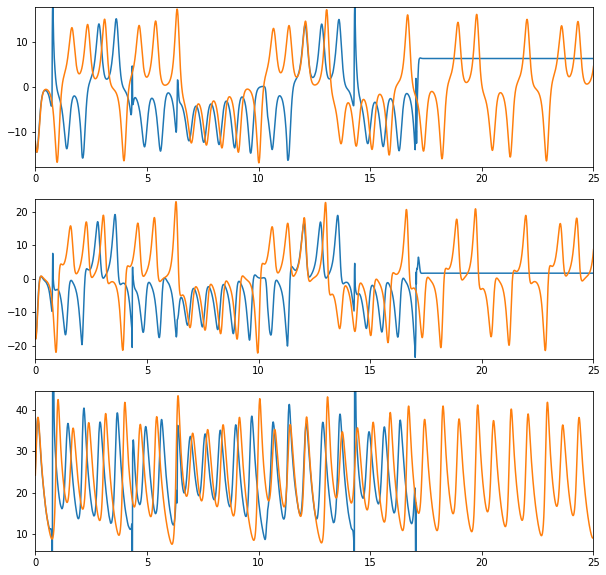

In [166]:
from easyesn.optimizers import GradientOptimizer
from easyesn import PredictionESN
from easyesn.optimizers import GridSearchOptimizer
from easyesn import helper as hlp
import matplotlib.pyplot as plt

# esn = PredictionESN(n_input=3, n_output=3, n_reservoir=200, leakingRate=0.2, regressionParameters=[1e-2], solver="lsqr", feedback=False)
# esn.fit(inputs, outputs, transientTime="Auto", verbose=1)

n_reservoir = 300
av_degree = 6
sparsity = 1 - av_degree/n_reservoir

# while True:
esn = PredictionESN(n_input=0, n_output=states.shape[1], n_reservoir=n_reservoir, spectralRadius=1.2, reservoirDensity=1-sparsity, leakingRate=0.5, regressionParameters=[1e-4], solver="lsqr", feedback=True)
# esn = PredictionESN(n_input=3, n_output=3, n_reservoir=300, leakingRate=1.0, regressionParameters=[1e-6], solver="lsqr", feedback=False)
# esn.fit(states[:-1,:], states[1:,:], transientTime=100, verbose=1)
esn.fit(None, states[:,:], transientTime=100, verbose=1)
generation = esn.generate(n=len(t_test), inputData=None, initialOutputData=states[-1,:])
# generation = esn.generate(n=len(t_test), inputData=states[-1,:], initialOutputData=states[-1,:])
#     print(np.mean((generation.T-states_test)**2))
#     if np.mean((generation.T-states_test)**2)<1000000000:
#         break



print(generation.shape)
print(states_test.shape)
print(generation[:,1])
print(states_test[1,:])
fig,ax = plt.subplots(3,1,figsize=(10,10))
for i in range(3):
    ax[i].plot(t_test,generation[i, :])
    ax[i].plot(t_test,states_test[:,i])
    ax[i].set_ylim([np.amin(states_test[:,i]),np.amax(states_test[:,i])])
    ax[i].set_xlim([np.amin(t_test[:]),25])
#     ax[i].set_xlim([np.amin(t_test[:]),np.amax(t_test[:])])
plt.show()

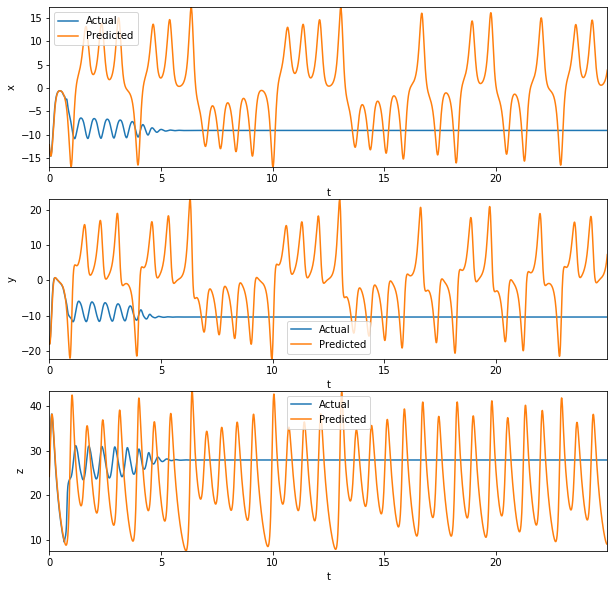

In [70]:
fig,ax = plt.subplots(3,1,figsize=(10,10))
for i in range(3):
    ax[i].plot(t_test,generation[i, :])
    ax[i].plot(t_test,states_test[:,i])
    ax[i].set_ylim([np.amin(states_test[:,i]),np.amax(states_test[:,i])])
    ax[i].set_xlim([np.amin(t_test[:]),np.amax(t_test[:])])
    ax[i].set_xlabel('t')
    ylabels = ['x','y','z']
    ax[i].set_ylabel(ylabels[i])
    ax[i].legend(['Actual','Predicted'])
plt.savefig('LorenzxyzOutput6.jpg')
plt.show()


In [36]:
import pickle

# obj0, obj1, obj2 are created here...

# Saving the objects:
with open('DataEasyESNLorenzSlecht.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump([states_test, generation], f)

In [56]:
import pickle
# Getting back the objects:
with open('DataEasyESNLorenz.pkl','rb') as f:  # Python 3: open(..., 'rb')
    states_test, generation = pickle.load(f)

In [ ]:
z = output_esn[:,2]
zover30 = z[z>30]
print(z)

plt.figure()
plt.scatter(states_test[:-1,2],states_test[1:,2])
plt.scatter(output_esn[:-1,2],output_esn[1:,2])
plt.xlim([30,45])
# plt.ylim([30,45])
plt.show()

##### K-S

Using Numpy backend.


Building Network


N/A% (0 of 39900) |                      | Elapsed Time: 0:00:00 ETA:  --:--:--

Fitting


100% (39900 of 39900) |##################| Elapsed Time: 0:38:24 Time:  0:38:24


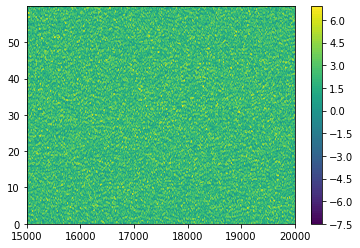

In [2]:
from easyesn.optimizers import GradientOptimizer
from easyesn import PredictionESN
from easyesn.optimizers import GridSearchOptimizer
from easyesn import helper as hlp
import matplotlib.pyplot as plt

# esn = PredictionESN(n_input=3, n_output=3, n_reservoir=200, leakingRate=0.2, regressionParameters=[1e-2], solver="lsqr", feedback=False)
# esn.fit(inputs, outputs, transientTime="Auto", verbose=1)

n_reservoir = 9000
av_degree = 3
sparsity = 1 - av_degree/n_reservoir

ygrids_train = ygrids[int(Nt/4):int(3*Nt/4),:]
ygrids_test = ygrids[int(3*Nt/4):,:]
t_train = t[int(Nt/4):int(3*Nt/4)]
t_test = t[int(3*Nt/4):]


# while True:
print("Building Network")
esn = PredictionESN(n_input=0, n_output=ygrids.shape[1], n_reservoir=n_reservoir, spectralRadius=0.4, reservoirDensity=1-sparsity, leakingRate=0.5, regressionParameters=[1e-4], solver="lsqr", feedback=True)
# esn = PredictionESN(n_input=3, n_output=3, n_reservoir=300, leakingRate=1.0, regressionParameters=[1e-6], solver="lsqr", feedback=False)
# esn.fit(states[:-1,:], states[1:,:], transientTime=100, verbose=1)
print("Fitting")
esn.fit(None, ygrids_train[:,:], transientTime=100, verbose=1)
generation = esn.generate(n=len(t_test), inputData=None, initialOutputData=ygrids_train[-1,:])
# generation = esn.generate(n=len(t_test), inputData=states[-1,:], initialOutputData=states[-1,:])
#     print(np.mean((generation.T-states_test)**2))
#     if np.mean((generation.T-states_test)**2)<1000000000:
#         break
del ygrids_train
del t_train


# print(generation.shape)
# print(states_test.shape)
# print(generation[:,1])
# print(states_test[1,:])
tmesh, xmesh = np.meshgrid(t_test, xgrid)

# print(ygrids)
# print(ygrids.shape)
fig = plt.figure()
ax = fig.gca()
colors = ax.contourf(tmesh,xmesh,generation,100)
plt.colorbar(colors,ax=ax)
plt.show()

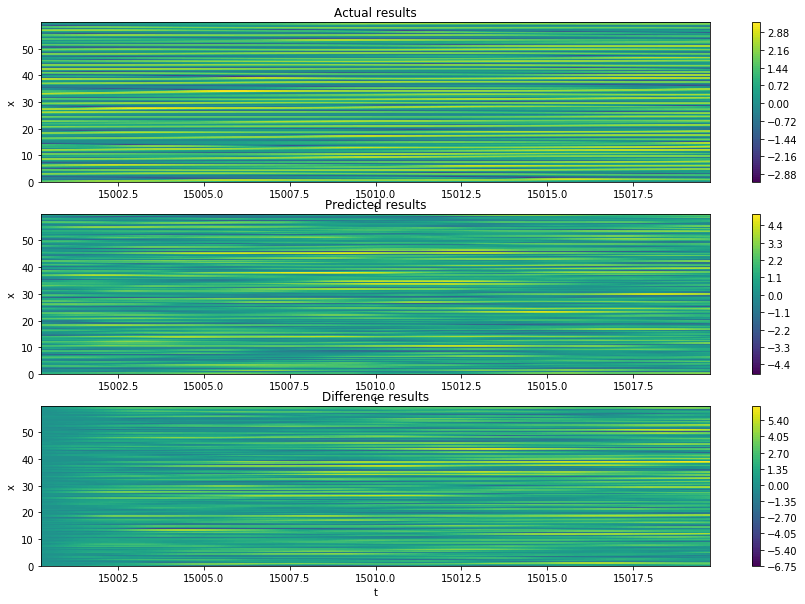

In [18]:
# print(ygrids)
# print(ygrids.shape)
fig,ax = plt.subplots(3,1,figsize=(15,10))

colors = ax[0].contourf(tmesh[:,1:80],xmesh[:,1:80],ygrids_test.T[:,1:80],100)
ax[0].set_xlabel('t')
ax[0].set_ylabel('x')
ax[0].set_title('Actual results')
plt.colorbar(colors,ax=ax[0])
# plt.show()
colors2 = ax[1].contourf(tmesh[:,1:80],xmesh[:,1:80],generation[:,1:80],100)
ax[1].set_xlabel('t')
ax[1].set_ylabel('x')
ax[1].set_title('Predicted results')
plt.colorbar(colors2,ax=ax[1])

colors3 = ax[2].contourf(tmesh[:,1:80],xmesh[:,1:80],ygrids_test.T[:,1:80]-generation[:,1:80],100)
ax[2].set_xlabel('t')
ax[2].set_ylabel('x')
ax[2].set_title('Difference results')
plt.colorbar(colors3,ax=ax[2])
plt.savefig('KSResultsDifference.jpg')
plt.show()

In [ ]:
import pickle

# obj0, obj1, obj2 are created here...

# Saving the objects:
with open('DataKMLangeTijd.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump([ygrids, t], f)

## Finding Lyupanov exponents

We have states

Need to define basis functions (polynomials BBA91)

Then determine coefficients c(m,k)

Then define the OSL matrix

Then we need to do QR decomposition (multiple times)

Then log of eigenvalues of R

In [147]:
import numpy as np
from numpy.linalg import *
import scipy

begin=0
eind=2400
tbegin = t_test[begin]
teind = t_test[eind]
verschiltijd = teind-begin

q_array = np.eye(states.shape[1])

lambda_array = np.zeros(states.shape[1])

for i in range(begin,eind+1):
    diff = df_dx(states_test[i,:],0)
    q_array, r_array = qr((diff@q_array)*(t[i+1]-t[i])+q_array)
    lambda_array += np.log(np.abs(np.diag(r_array)))/verschiltijd

print(lambda_array)

# matrix = np.eye(states.shape[1])
# for i in range(begin,eind+1):
#     matrix = df_dx(states[i],0).T @ matrix
# matrix = matrix.T @ matrix
# matrix = scipy.linalg.fractional_matrix_power(matrix, 1/(2*(eind-begin)))
# # matrix = matrix_power(matrix,1/(2*(eind-begin)))
# print(eig(matrix))

[  1.21246611   0.45228122 -15.84696299]


In [146]:
import numpy as np
from numpy.linalg import *
import scipy

if generation.shape[0]<generation.shape[1]:
    generation = generation.T

begin=0
eind=2400
tbegin = t_test[begin]
teind = t_test[eind]
verschiltijd = teind-begin

q_array = np.eye(states.shape[1])

lambda_array = np.zeros(states.shape[1])

for i in range(begin,eind+1):
    diff = df_dx(generation[i,:],0)
    q_array, r_array = qr((diff@q_array)*(t[i+1]-t[i])+q_array)
    lambda_array += np.log(np.abs(np.diag(r_array)))/verschiltijd

print(lambda_array)

[  0.95827287   0.42558751 -15.24618999]


In [144]:
import numpy as np
from numpy.linalg import *
import scipy
if generation.shape[0]<generation.shape[1]:
    generation = generation.T

begin=100
eind=2400
tbegin = t_test[begin]
teind = t_test[eind]
verschiltijd = teind-begin

q_array = np.eye(states.shape[1])

lambda_array = np.zeros(states.shape[1])

for i in range(begin,eind+1):
    diff = np.zeros((3,3))
    for ix in range(3):
        for iy in range(3):
            diff[ix,iy] = (generation[i+1,ix]-generation[i-1,ix])/(generation[i+1,iy]-generation[i-1,iy]+1e-10)
    q_array, r_array = qr((diff@q_array)*(t[i+1]-t[i])+q_array)
    lambda_array += np.log(np.abs(np.diag(r_array)))/verschiltijd

print(lambda_array)

[-0.75973035 -0.14478019  0.0095789 ]


In [145]:
import numpy as np
from numpy.linalg import *
import scipy
if generation.shape[0]<generation.shape[1]:
    generation = generation.T

begin=10
eind=2400
tbegin = t_test[begin]
teind = t_test[eind]
verschiltijd = teind-begin

q_array = np.eye(states.shape[1])

lambda_array = np.zeros(states.shape[1])

for i in range(begin,eind+1):
    diff = np.zeros((3,3))
    for ix in range(3):
        for iy in range(3):
            diff[ix,iy] = (states_test[i+1,ix]-states_test[i-1,ix])/(states_test[i+1,iy]-states_test[i-1,iy])
    q_array, r_array = qr((diff@q_array)*(t[i+1]-t[i])+q_array)
    lambda_array += np.log(np.abs(np.diag(r_array)))/verschiltijd

print(lambda_array)

[-0.72806361 -0.26084329  0.09397527]


In [ ]:
import numpy as np
from numpy.linalg import *
import scipy
import numba as nb
from tqdm import tqdm
# if generation.shape[0]<generation.shape[1]:
#     generation = generation.T

begin=10
eind=2400
tbegin = t[begin]
teind = t[eind]
verschiltijd = teind-begin

print(ygrids.shape)

q_array = np.eye(ygrids.shape[1])

lambda_array = np.zeros(ygrids.shape[1])

dimension = ygrids.shape[1]

@nb.njit
def diff_calc(matrix,time_point,dim):
    diff = np.zeros((dim,dim))
    for ix in range(dim):
        for iy in range(dim):
            diff[ix,iy] = (matrix[time_point+1,ix]-matrix[time_point-1,ix])/(matrix[time_point+1,iy]-matrix[time_point-1,iy])
    return diff

for i in tqdm(range(begin,eind+1)):
    diff = diff_calc(generation.T,i,dimension)
    q_array, r_array = qr((diff@q_array)*(verschiltijd)+q_array)
    lambda_array += np.log(np.abs(np.diag(r_array)))/verschiltijd

print(lambda_array)

  0%|                                                                                         | 0/2391 [00:00<?, ?it/s]

(80001, 600)


 90%|██████████████████████████████████████████████████████████████████████▌       | 2163/2391 [03:57<00:24,  9.37it/s]

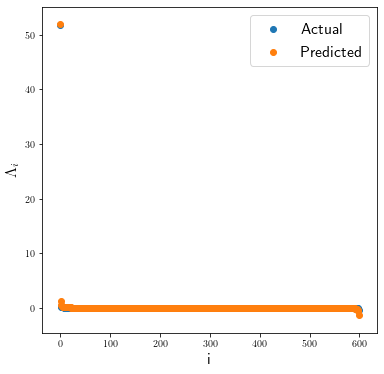

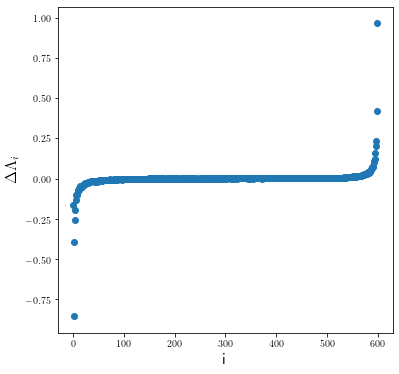

[-1.64693400e-01 -8.57189918e-01 -3.93244956e-01 -2.57870568e-01
 -1.93609451e-01 -1.31740494e-01 -1.05002757e-01 -9.71855472e-02
 -1.01472625e-01 -7.60505900e-02 -7.19071201e-02 -6.84071630e-02
 -5.91855392e-02 -5.55028732e-02 -4.87314465e-02 -4.87012834e-02
 -5.25648540e-02 -4.37942072e-02 -5.21977452e-02 -3.87646773e-02
 -3.80309542e-02 -3.96361409e-02 -3.63778120e-02 -3.36198674e-02
 -2.88315756e-02 -2.83826044e-02 -2.74228018e-02 -2.78129156e-02
 -2.71370262e-02 -2.44618713e-02 -2.91936511e-02 -2.46659066e-02
 -2.01418513e-02 -2.23457905e-02 -2.43727631e-02 -1.81480621e-02
 -1.82512883e-02 -1.84502129e-02 -1.84183972e-02 -1.34164417e-02
 -1.71024768e-02 -1.71091180e-02 -1.63933567e-02 -1.75060322e-02
 -1.85838239e-02 -1.57678246e-02 -1.71859047e-02 -2.26251668e-02
 -1.94191595e-02 -1.65268526e-02 -1.56399114e-02 -1.13632055e-02
 -1.46642145e-02 -1.71301809e-02 -1.11986832e-02 -1.13739410e-02
 -7.94006984e-03 -1.24383308e-02 -1.10325231e-02 -9.00404510e-03
 -8.73487556e-03 -8.08808

In [31]:
import matplotlib.pyplot as plt
plt.rc('text',usetex = True)
import numpy as np

fig = plt.figure(figsize=(6,6))
plt.scatter(range(len(lyupanovs_ks_measured)),lyupanovs_ks_measured)
plt.scatter(range(len(lyupanovs_ks_ESN)),lyupanovs_ks_ESN)
plt.legend(['Actual','Predicted'],fontsize=16)
plt.xlabel('i',fontsize=16)
plt.ylabel('$\Lambda_i$',fontsize=16)
plt.savefig('LyupanovsKS.jpeg')
plt.show()

fig = plt.figure(figsize=(6,6))
plt.scatter(range(len(lyupanovs_ks_measured)),(np.array(lyupanovs_ks_measured)-np.array(lyupanovs_ks_ESN)))
# plt.legend(['Actual','Predicted'])
plt.xlabel('i',fontsize=16)
plt.ylabel('$\Delta \Lambda_i$',fontsize=16)
plt.savefig('LyupanovsKS_difference_absolute.jpeg')
plt.show()
print((np.array(lyupanovs_ks_measured)-np.array(lyupanovs_ks_ESN)))

In [3]:
lyupanovs_ks_measured = [ 5.17466786e+01,  3.38416182e-01,  1.90052874e-01,  1.21519691e-01
,  9.45246219e-02,  8.84717007e-02,  6.75579890e-02,  6.08102128e-02
,  4.97244887e-02,  4.50349280e-02,  4.32266589e-02,  3.60530070e-02
,  3.28188868e-02,  3.15379529e-02,  3.00707820e-02,  2.37689500e-02
,  2.14173980e-02,  2.78863088e-02,  1.79874758e-02,  2.35227238e-02
,  1.99480596e-02,  1.71849829e-02,  1.63612129e-02,  1.66713878e-02
,  1.62017577e-02,  1.55725563e-02,  1.55815666e-02,  1.24938482e-02
,  1.38648529e-02,  1.42921839e-02,  9.90082060e-03,  1.28583087e-02
,  1.06249986e-02,  1.07634952e-02,  1.03881529e-02,  1.22491518e-02
,  1.03018027e-02,  9.90841713e-03,  8.60181795e-03,  1.21542761e-02
,  1.07809772e-02,  9.00269301e-03,  7.85920902e-03,  7.74238257e-03
,  8.27495453e-03,  7.01204508e-03,  7.17895397e-03,  5.99884296e-03
,  5.57748463e-03,  6.30621543e-03,  7.76105552e-03,  6.63059940e-03
,  7.17756760e-03,  5.20469138e-03,  8.43661314e-03,  5.60819945e-03
,  7.60083446e-03,  4.69077045e-03,  6.58103961e-03,  5.90982540e-03
,  8.62508314e-03,  6.54392067e-03,  5.30547018e-03,  7.15779912e-03
,  4.38000436e-03,  3.93182884e-03,  6.61302118e-03,  5.12542486e-03
,  5.00553993e-03,  4.02418601e-03,  3.27055669e-03,  5.53557125e-03
,  2.63994347e-03,  7.11241497e-03,  3.65262119e-03,  3.33411274e-03
,  3.27808711e-03,  4.12907794e-03,  3.21724652e-03,  1.97783379e-03
,  4.54786351e-03,  3.87970901e-03,  2.85398755e-03,  4.72098102e-03
,  3.78106215e-03,  3.01530726e-03,  3.08288422e-03,  2.76934113e-03
,  3.44078313e-03,  3.27755385e-03,  3.42415084e-03,  2.89058033e-03
,  2.93898733e-03,  4.27587114e-03,  2.63027305e-03,  4.21255280e-03
,  2.07077737e-03,  5.79954729e-03,  3.65935465e-03,  5.73156668e-03
,  5.32216610e-03,  2.23636834e-03,  2.83774362e-03,  6.07359669e-04
,  1.05657713e-03,  2.33022681e-03,  2.59884994e-03,  1.79568985e-03
,  1.72284138e-03,  2.82923384e-03,  3.38703436e-03,  3.54714407e-03
,  2.02145263e-03,  1.88889482e-03,  1.68347090e-03,  2.04578264e-03
,  2.19126282e-03,  2.53013716e-03,  9.24211870e-04,  1.88736583e-03
,  1.78514452e-03,  1.91644372e-03,  2.97404902e-04,  1.34127944e-03
,  2.54738278e-03,  2.10089318e-03,  1.69669526e-03,  1.98410389e-03
,  2.25783691e-03,  2.09415539e-04,  1.14883169e-03,  1.66135119e-03
,  1.09888334e-03,  7.80496778e-04,  1.49494069e-03,  1.15656627e-03
,  1.49538089e-03,  1.21498949e-03,  1.70270170e-03, -2.03178464e-04
,  7.89677518e-04,  2.32761595e-03,  1.07161575e-03,  2.28212116e-03
,  2.67519654e-03,  1.44611063e-03,  2.94866422e-03,  4.34039760e-04
,  3.91589819e-04,  3.28662365e-03,  1.84852330e-03,  1.47210031e-03
,  1.88743073e-03,  3.26468198e-03,  2.02923410e-03,  2.49247028e-03
,  2.16472899e-04,  3.91206590e-03,  4.81489119e-04,  1.48600714e-03
,  5.14485888e-03,  1.06183987e-03,  5.34163969e-04,  1.61346499e-03
,  2.78329248e-03,  2.71720269e-03,  1.73710040e-03,  2.49052963e-03
,  1.99511073e-03,  1.34002037e-03,  1.45421285e-03,  2.48045314e-03
,  1.23483328e-03,  1.70500963e-03,  1.81205552e-03,  4.95081463e-04
,  9.99888479e-04,  1.43472711e-03,  1.18839761e-03, -4.40859075e-05
,  1.99030354e-04,  1.10407548e-03,  5.82450759e-04,  1.26780576e-03
,  9.83935075e-04,  1.16732757e-03,  1.13285281e-03,  2.25978838e-03
,  5.76140301e-04,  2.03831266e-04,  1.43520504e-03,  1.35500965e-03
,  9.62499350e-04,  1.63788499e-03,  1.55826510e-03,  1.23369155e-03
,  5.67500730e-04,  1.59449038e-03,  6.09137536e-04,  1.87260002e-03
,  3.50783017e-04,  2.18668316e-03,  1.10643646e-03,  6.66884335e-04
,  9.86321824e-04, -5.26471947e-05,  3.76581622e-04,  1.99533503e-04
, -3.50212080e-05, -1.71233636e-05,  2.04211641e-04, -1.18443404e-04
,  1.24628481e-03, -1.05338406e-04,  1.27520775e-03, -1.64056789e-04
, -1.26033294e-04,  3.98589174e-04,  1.22362031e-03,  3.33502032e-05
,  7.79913895e-04,  2.58279432e-03,  1.14983485e-03,  7.04435087e-04
,  7.79274014e-04,  1.47892020e-03,  2.39772427e-03,  3.62926905e-04
,  5.86834878e-04,  1.97237055e-03,  2.03653575e-04,  5.40199901e-04
,  4.00808628e-04,  1.17042799e-04, -8.46489474e-05, -5.08930434e-04
,  1.90293180e-03,  1.23464277e-03,  1.77369989e-04,  7.74105072e-04
,  2.83818663e-04, -2.82905134e-04,  4.72592384e-04,  3.00825762e-04
, -5.20994241e-04, -5.08277259e-04, -4.78877193e-04, -4.17463194e-04
, -2.42892634e-04,  1.58460697e-04,  1.67061834e-04, -3.12534917e-04
,  1.75106010e-04, -9.67651782e-05,  6.55566503e-05, -5.88976735e-04
, -6.80258802e-04,  2.67993572e-05, -7.10421652e-04, -4.10560579e-04
, -1.07146193e-03, -3.22577962e-04,  4.24587716e-04, -3.92198443e-04
, -4.88876494e-04, -5.92405035e-04, -9.70229489e-05, -3.50659368e-04
, -6.68747464e-04,  1.58749512e-03, -1.65012212e-04,  2.96918624e-04
, -1.85987456e-04, -5.02891959e-04, -2.33319776e-04,  1.66976181e-03
,  2.51707893e-04,  4.48402156e-05, -1.33678626e-04, -2.06262488e-04
, -9.25462383e-05,  1.55849782e-03,  2.07193944e-04, -3.13968730e-04
, -2.14612720e-04, -1.58512041e-04, -2.32592252e-04,  1.31551980e-03
, -5.20270716e-04,  4.03662465e-04, -3.21969879e-04, -2.67320413e-04
, -5.45763030e-04, -5.45866932e-04,  1.16594795e-03,  3.07511500e-04
, -2.35391071e-04, -2.62146052e-04, -6.57805725e-04, -2.54116829e-04
, -4.91070317e-04, -8.07734754e-04, -7.49165903e-04, -4.77390280e-04
, -5.76020527e-04, -3.50451261e-04, -5.85796972e-04, -5.46853912e-04
, -5.61635825e-04, -3.71842493e-04, -8.18736851e-04, -9.07773120e-04
, -6.33788077e-04, -1.39337296e-03, -1.27546323e-03, -9.42373716e-04
, -1.02650958e-03, -1.48547161e-04, -4.15288879e-04, -9.22958550e-04
, -8.90354115e-04, -9.56719927e-04, -9.55828708e-04, -1.06171851e-03
,  8.03553821e-05, -5.07155743e-04, -6.15698876e-04, -5.55606401e-04
, -7.60602151e-04, -9.88810454e-04, -5.25263764e-04, -5.32057790e-04
, -1.03612768e-03, -1.04373291e-03, -9.69376916e-04, -3.59073261e-04
, -6.59583183e-04, -1.16495890e-05, -1.45255920e-04, -8.34794858e-04
, -8.99399226e-04, -5.53737104e-04, -2.28172151e-04, -8.16361339e-04
, -8.12705875e-04, -1.36297756e-03, -1.18596008e-03, -1.07553683e-03
, -9.57587762e-04, -1.00787258e-03, -1.37934903e-03, -1.25450655e-03
, -1.32362405e-03, -1.13542063e-03, -1.59688139e-03, -1.21358945e-03
, -1.06552348e-03, -1.20739741e-03, -1.32503088e-03, -9.24575698e-04
, -7.80565483e-04, -7.40558470e-04, -7.66705159e-04, -5.27919554e-04
, -8.70269213e-04, -1.00126902e-03, -1.15539453e-03, -1.32051969e-03
, -1.31316396e-03, -1.00144498e-03, -1.38505314e-03, -1.53723671e-03
, -1.64942028e-03, -1.27298425e-03, -1.54453136e-03, -1.55119462e-03
, -1.82822984e-03, -1.68335311e-03, -1.40634885e-03, -1.22520175e-03
, -1.45859997e-03, -1.48059487e-03, -1.58166399e-03, -5.53258707e-04
, -7.23320975e-04, -6.78072015e-04, -5.85115553e-04, -1.04939337e-03
, -9.82944379e-04, -1.53237205e-03, -1.61842398e-03, -1.81774353e-03
, -1.79104749e-03, -1.51260181e-03, -1.78097582e-03, -1.38308859e-03
, -1.63216756e-03, -1.88318817e-03, -1.49303041e-03, -1.40628420e-03
, -1.36916503e-03, -1.34361616e-03, -1.74561549e-03, -1.45137667e-03
, -1.57597652e-03, -1.38119139e-03, -1.79810312e-03, -1.80985923e-03
, -1.80960264e-03, -2.11793610e-03, -1.67954098e-03, -1.43460330e-03
, -1.12455332e-03, -1.07827613e-03, -1.24133608e-03, -9.17950424e-04
, -7.13429957e-04, -8.11640743e-04, -9.09085416e-04, -1.18017851e-03
, -1.17226297e-03, -1.43512505e-03, -1.47407329e-03, -1.36342120e-03
, -6.90863339e-04, -1.00430905e-03, -1.22921693e-03, -1.65907510e-03
, -1.35839009e-03, -1.07374250e-03, -1.36686517e-03, -1.40405715e-03
, -1.28655541e-03, -1.45762711e-03, -1.55731402e-03, -1.33031311e-03
, -1.04255616e-03, -1.16676432e-03, -1.40269566e-03, -1.58820599e-03
, -1.57791920e-03, -1.43328086e-03, -1.52021755e-03, -1.64719111e-03
, -1.46333854e-03, -1.52137943e-03, -2.11453274e-03, -2.67382346e-03
, -1.88599609e-03, -1.97476736e-03, -2.13402675e-03, -2.23034693e-03
, -1.88385435e-03, -1.64542307e-03, -2.26085622e-03, -1.75242605e-03
, -1.42519880e-03, -1.54466194e-03, -1.80811574e-03, -1.71684325e-03
, -1.66060890e-03, -1.64594899e-03, -1.98436046e-03, -1.84059960e-03
, -1.64172625e-03, -1.65727483e-03, -1.27594173e-03, -1.39540754e-03
, -1.58341496e-03, -1.58598416e-03, -1.96662893e-03, -2.14568432e-03
, -2.69070621e-03, -2.08476401e-03, -2.59710814e-03, -2.66914750e-03
, -2.59628744e-03, -2.75123481e-03, -2.84568796e-03, -3.15356378e-03
, -3.34484460e-03, -2.91491665e-03, -3.00910038e-03, -2.95112988e-03
, -2.47701797e-03, -2.45737990e-03, -2.41150515e-03, -2.28998354e-03
, -2.11636046e-03, -2.24593613e-03, -2.40539819e-03, -2.46483987e-03
, -2.35376600e-03, -2.46866021e-03, -2.53175312e-03, -2.62590070e-03
, -2.55888857e-03, -3.19646001e-03, -3.21839377e-03, -2.56164573e-03
, -2.52710421e-03, -2.48368306e-03, -2.71824987e-03, -2.40008446e-03
, -2.38615340e-03, -3.00214921e-03, -3.10356096e-03, -2.93225814e-03
, -3.31345871e-03, -2.78779233e-03, -3.36675091e-03, -2.66084642e-03
, -2.94118505e-03, -3.23746808e-03, -4.01660222e-03, -3.65795588e-03
, -3.76124368e-03, -4.48398932e-03, -3.55822618e-03, -3.83160948e-03
, -4.13342560e-03, -3.90496040e-03, -4.46401613e-03, -4.54446299e-03
, -4.03160167e-03, -3.78898427e-03, -3.94062482e-03, -4.01418756e-03
, -4.43963543e-03, -4.47794777e-03, -4.38239119e-03, -4.07702650e-03
, -4.31065266e-03, -4.34186562e-03, -4.28654388e-03, -3.82449673e-03
, -4.49355866e-03, -4.12860899e-03, -3.50701422e-03, -4.19156369e-03
, -4.50373102e-03, -4.35110140e-03, -4.63070946e-03, -4.76525711e-03
, -4.50610290e-03, -5.09003160e-03, -6.02577695e-03, -5.91466613e-03
, -6.51991034e-03, -5.07813195e-03, -5.13373727e-03, -4.55511203e-03
, -5.03105119e-03, -5.22569976e-03, -6.00181540e-03, -5.93160894e-03
, -7.45770042e-03, -7.92416145e-03, -6.91485948e-03, -7.57629594e-03
, -6.99644527e-03, -8.53371981e-03, -8.12842378e-03, -8.28756185e-03
, -9.93409421e-03, -8.98338805e-03, -1.15033896e-02, -9.13852121e-03
, -8.65361854e-03, -9.63528808e-03, -1.16130033e-02, -1.35245641e-02
, -1.26665047e-02, -1.40533867e-02, -1.31607906e-02, -1.52201931e-02
, -1.50928104e-02, -1.56964095e-02, -1.76784932e-02, -1.94689311e-02
, -1.77998931e-02, -2.17185709e-02, -1.93029351e-02, -2.55250110e-02
, -2.49116405e-02, -2.81563703e-02, -2.43671194e-02, -2.71567854e-02
, -3.04087998e-02, -3.60493909e-02, -3.11277201e-02, -4.13514064e-02
, -4.67678995e-02, -4.88916142e-02, -5.97107049e-02, -6.90317901e-02
, -8.64779736e-02, -1.25507663e-01, -1.67001641e-01, -3.62653999e-01]

lyupanovs_ks_ESN = [ 5.19113720e+01,  1.19560610e+00,  5.83297830e-01,  3.79390259e-01
,  2.88134073e-01,  2.20212195e-01,  1.72560746e-01,  1.57995760e-01
,  1.51197114e-01,  1.21085518e-01,  1.15133779e-01,  1.04460170e-01
,  9.20044260e-02,  8.70408261e-02,  7.88022285e-02,  7.24702334e-02
,  7.39822520e-02,  7.16805160e-02,  7.01852210e-02,  6.22874011e-02
,  5.79790138e-02,  5.68211238e-02,  5.27390249e-02,  5.02912552e-02
,  4.50333333e-02,  4.39551607e-02,  4.30043684e-02,  4.03067638e-02
,  4.10018791e-02,  3.87540552e-02,  3.90944717e-02,  3.75242153e-02
,  3.07668499e-02,  3.31092857e-02,  3.47609160e-02,  3.03972139e-02
,  2.85530910e-02,  2.83586300e-02,  2.70202152e-02,  2.55707178e-02
,  2.78834540e-02,  2.61118110e-02,  2.42525657e-02,  2.52484148e-02
,  2.68587784e-02,  2.27798697e-02,  2.43648587e-02,  2.86240098e-02
,  2.49966441e-02,  2.28330680e-02,  2.34009669e-02,  1.79938049e-02
,  2.18417821e-02,  2.23348723e-02,  1.96352963e-02,  1.69821404e-02
,  1.55409043e-02,  1.71291012e-02,  1.76135627e-02,  1.49138705e-02
,  1.73599587e-02,  1.46320019e-02,  1.32752637e-02,  1.42385828e-02
,  1.51731409e-02,  1.56814652e-02,  1.31455137e-02,  1.24475208e-02
,  1.45362126e-02,  1.24146565e-02,  1.15567774e-02,  1.32606310e-02
,  1.18301617e-02,  1.15736064e-02,  1.14488875e-02,  1.03921328e-02
,  1.15438275e-02,  1.16271265e-02,  9.96254723e-03,  1.17799463e-02
,  1.08766768e-02,  9.00454274e-03,  8.91813463e-03,  8.34766192e-03
,  9.46868294e-03,  8.15776112e-03,  9.98608042e-03,  8.93567292e-03
,  8.68412625e-03,  8.04344756e-03,  7.15504784e-03,  5.36211353e-03
,  7.43719715e-03,  9.08478052e-03,  6.68244897e-03,  7.61826683e-03
,  8.29405211e-03,  6.16128659e-03,  7.88515440e-03,  7.26075875e-03
,  7.14980531e-03,  7.50401985e-03,  5.65854383e-03,  4.92372863e-03
,  5.77390683e-03,  5.93418912e-03,  7.44504676e-03,  5.17239550e-03
,  5.05836829e-03,  4.49101238e-03,  5.07199545e-03,  5.91811850e-03
,  4.36676895e-03,  5.22815587e-03,  5.36165304e-03,  4.63749670e-03
,  4.32816578e-03,  4.19948693e-03,  3.80862033e-03,  4.93283015e-03
,  4.11220601e-03,  3.48926343e-03,  3.94080239e-03,  3.87383489e-03
,  5.19654333e-03,  4.24929723e-03,  4.04457596e-03,  3.30446959e-03
,  4.17980128e-03,  3.43443900e-03,  3.30931128e-03,  2.99707143e-03
,  2.24673934e-03,  2.58763107e-03,  2.28069542e-03,  2.30459023e-03
,  2.50350747e-03,  1.70383048e-03,  3.56821069e-03,  2.79082001e-03
,  2.71129354e-03,  3.80490494e-03,  3.07193769e-03,  2.33130032e-03
,  2.63867167e-03,  3.25929331e-03,  3.58851144e-03,  2.52107798e-03
,  2.74009401e-03,  2.24151532e-03,  3.15005500e-03,  1.75649486e-03
,  2.74706424e-03,  1.55066339e-03,  2.18854053e-03,  3.12407437e-03
,  2.64783017e-03,  1.80368876e-03,  2.78243330e-03,  3.32788324e-03
,  1.49608809e-03,  1.74351769e-03,  2.43120655e-03,  2.20336446e-03
,  1.72289037e-03,  1.45123100e-03,  2.20669368e-03,  2.09178201e-03
,  2.85558710e-03,  1.94331697e-03,  1.96225006e-03,  1.65703115e-03
,  1.66312735e-03,  9.04657530e-04,  1.14805611e-03,  8.70433349e-04
,  1.31324884e-03,  1.06052808e-03,  6.91074432e-04,  1.60610796e-03
,  1.40551158e-03,  1.62533669e-03,  1.35204545e-03,  2.28227890e-03
,  8.05085856e-04,  1.63561928e-03,  1.85169438e-03,  9.87371238e-04
,  1.37000565e-03,  4.22449488e-04,  1.15145552e-03,  5.95673862e-04
,  1.17509935e-03,  1.45876857e-03,  2.28630856e-03,  9.66816713e-04
,  3.10488639e-03,  9.16136698e-04,  1.49070892e-03,  8.23492462e-04
,  7.68796077e-04,  5.26013914e-04,  4.30321611e-04,  5.10385566e-04
,  9.61080725e-04,  5.51803587e-04,  2.87577888e-04,  1.15904467e-05
,  1.11978022e-03,  7.82200437e-04,  1.22684449e-03,  6.82705975e-04
,  1.62108608e-03,  1.92886459e-03,  3.68539794e-04,  2.32579720e-04
,  1.81500326e-04,  8.89306579e-05,  1.40413960e-03,  2.59318233e-04
,  1.54002186e-03,  9.00149438e-04,  6.36735356e-04,  3.38485396e-04
,  7.06929156e-04,  5.08037488e-04,  1.19569624e-04, -1.33685037e-04
, -2.00654764e-04,  1.63723257e-04,  3.58593519e-04,  7.52256543e-04
,  3.89145223e-04,  6.65790268e-08,  7.79394738e-05,  7.92784461e-04
,  4.92299413e-05, -4.75468652e-05,  6.14354317e-05,  4.37835914e-04
,  6.47407887e-04,  1.63533509e-04,  1.24912170e-04,  5.26872434e-04
,  8.80867218e-04,  3.61755230e-04,  1.62846450e-04,  1.85493370e-04
,  2.97568149e-04,  2.03568802e-04, -8.39174534e-05, -5.90112726e-05
, -7.72762600e-05, -2.15927470e-04, -3.95013727e-04, -2.11974482e-04
, -2.25056155e-04, -1.10726005e-04, -1.24089213e-04, -6.17701969e-04
,  5.97702522e-04,  4.44272754e-05, -4.47066230e-04, -7.04862162e-06
,  1.96598437e-04,  8.50334274e-05, -6.33813361e-04, -6.79181353e-04
, -6.98528159e-04, -3.41067355e-04,  4.54743649e-03,  6.48156320e-04
,  2.01150558e-04, -1.73623730e-04, -3.45293069e-04, -5.32723957e-04
, -4.23728979e-04, -3.67802493e-04, -3.42847676e-04,  2.22884292e-04
, -2.36773137e-04, -4.74590812e-04, -2.21090429e-04, -9.47469318e-05
, -5.16061270e-04,  4.02109399e-04, -2.40624055e-04, -6.74823779e-04
, -7.13162627e-04, -8.16834362e-04, -3.40806558e-04, -5.34533810e-04
, -4.28324702e-04, -6.02399008e-04, -1.06352622e-03, -8.52981252e-04
, -5.17952333e-04, -5.65822997e-04, -9.23329647e-04, -1.23001080e-03
, -3.71377077e-04,  2.46660352e-04, -4.36363614e-04, -9.39150769e-04
, -9.80598722e-04, -8.51869404e-04, -7.97859638e-04, -1.34482769e-03
, -1.34679078e-03, -1.45428919e-03, -1.34065581e-03, -8.00133906e-05
, -3.81972223e-04,  2.27561531e-05, -6.54920804e-04, -9.75227852e-04
, -8.92619933e-04, -7.57442390e-04, -8.59333668e-04, -1.26075774e-03
, -1.10280327e-03, -1.19177358e-03, -1.12162608e-03, -1.02877489e-03
, -8.36280120e-04, -1.33025357e-03, -1.43782144e-03, -1.28241897e-03
, -1.19716969e-03, -1.45370189e-03, -7.44960633e-04, -7.95864765e-04
, -1.14824060e-03, -1.42482774e-03, -1.52923736e-03, -1.53914680e-03
, -1.29046651e-03, -1.32014530e-03, -1.10051745e-03, -1.76403536e-03
, -1.73667223e-03, -1.50361434e-03, -1.56970232e-03, -1.57684763e-03
, -1.13075575e-03, -1.38036217e-03, -1.48130522e-03, -1.42198720e-03
, -9.19619115e-04, -1.65377260e-03, -1.89430493e-03, -1.64185813e-03
, -1.64152701e-03, -1.96144641e-03, -1.63658475e-03, -1.43492717e-03
, -1.55453652e-03, -1.67549004e-03, -2.03694636e-03, -1.69965378e-03
, -1.83924295e-03, -2.03751821e-03, -1.48798187e-03, -1.65699594e-03
, -1.84958947e-03, -2.16442121e-03, -2.19478500e-03, -2.14450357e-03
, -2.17628842e-03, -1.97857692e-03, -1.67827847e-03, -1.54105251e-03
, -2.05823639e-03, -1.93874906e-03, -2.04191616e-03, -1.91547160e-03
, -2.34810606e-03, -2.39968316e-03, -2.00989515e-03, -1.84762274e-03
, -2.02273580e-03, -1.81638108e-03, -2.11831531e-03, -1.82251870e-03
, -1.99987887e-03, -2.46340113e-03, -2.56017612e-03, -2.25102232e-03
, -2.71338942e-03, -2.57051099e-03, -2.25156862e-03, -1.96895180e-03
, -2.07392593e-03, -2.58433971e-03, -2.50915592e-03, -2.76925317e-03
, -2.46483740e-03, -2.35323259e-03, -2.01387940e-03, -1.77105122e-03
, -1.49462657e-03, -2.09577771e-03, -2.52442072e-03, -2.48593770e-03
, -2.63344032e-03, -2.85739633e-03, -2.50704006e-03, -2.64430992e-03
, -2.69796145e-03, -2.80118102e-03, -2.95633760e-03, -2.49248662e-03
, -2.93190727e-03, -2.75358299e-03, -2.74790255e-03, -3.12998346e-03
, -3.14820005e-03, -3.11231119e-03, -2.83543121e-03, -2.88101118e-03
, -2.66801592e-03, -2.97878159e-03, -3.02078083e-03, -2.95294698e-03
, -3.30883519e-03, -2.78504643e-03, -3.12816532e-03, -2.77896938e-03
, -2.84296485e-03, -3.25071923e-03, -3.47365318e-03, -3.69266237e-03
, -3.58577917e-03, -3.71997652e-03, -3.78271503e-03, -3.63927194e-03
, -3.65033556e-03, -3.21127875e-03, -3.08036224e-03, -3.60778823e-03
, -3.48675340e-03, -3.55998176e-03, -3.97138164e-03, -3.80258317e-03
, -3.48366852e-03, -3.86312870e-03, -3.54350371e-03, -3.67266244e-03
, -3.96122270e-03, -3.20689194e-03, -3.38110786e-03, -4.35745531e-03
, -4.14503940e-03, -3.71847569e-03, -4.26790581e-03, -3.93920903e-03
, -4.60870095e-03, -4.44241906e-03, -3.89563235e-03, -4.61302793e-03
, -4.92441776e-03, -4.97566910e-03, -3.80380190e-03, -3.74418660e-03
, -3.69752580e-03, -4.08195445e-03, -4.72124620e-03, -4.79565090e-03
, -4.51919448e-03, -4.56415894e-03, -4.54603281e-03, -4.79779685e-03
, -5.17239549e-03, -5.62267257e-03, -5.20373147e-03, -5.12048920e-03
, -5.63851400e-03, -4.87821249e-03, -4.95841161e-03, -5.03990783e-03
, -4.82400177e-03, -5.37688970e-03, -4.97088393e-03, -4.68972654e-03
, -5.18086754e-03, -5.59077288e-03, -5.65512288e-03, -5.41967943e-03
, -5.80590026e-03, -4.91594954e-03, -5.47701162e-03, -6.03570407e-03
, -6.22725275e-03, -5.70800451e-03, -6.57210363e-03, -5.88711885e-03
, -6.09192871e-03, -5.99020436e-03, -6.51444345e-03, -6.61701758e-03
, -5.82434490e-03, -6.50681395e-03, -6.55909301e-03, -6.78775033e-03
, -6.53503503e-03, -7.16939667e-03, -6.98629691e-03, -6.63899967e-03
, -7.26568430e-03, -6.65297607e-03, -7.12020245e-03, -7.71662912e-03
, -7.24763289e-03, -7.40977694e-03, -7.55631311e-03, -7.95185233e-03
, -7.75164272e-03, -8.23118469e-03, -8.21199592e-03, -7.86094285e-03
, -8.46364721e-03, -8.54662229e-03, -8.37984319e-03, -8.05249116e-03
, -9.93590808e-03, -9.81353061e-03, -9.79960653e-03, -8.98169928e-03
, -9.61974464e-03, -9.51992953e-03, -9.28625910e-03, -1.00856502e-02
, -1.03224733e-02, -1.04514978e-02, -1.10322753e-02, -1.06175895e-02
, -1.06403439e-02, -1.03124014e-02, -1.01915608e-02, -1.35361251e-02
, -1.23867416e-02, -1.27314420e-02, -1.25969564e-02, -1.43667552e-02
, -1.38186254e-02, -1.28292021e-02, -1.45174621e-02, -1.45066707e-02
, -1.58500522e-02, -1.57718584e-02, -1.66456970e-02, -1.77789635e-02
, -1.72619822e-02, -1.79753308e-02, -2.12860208e-02, -1.84242653e-02
, -1.89549879e-02, -2.00191381e-02, -2.13404290e-02, -2.05411316e-02
, -2.24250773e-02, -2.50637489e-02, -2.53538514e-02, -2.47059347e-02
, -2.59139822e-02, -2.68979637e-02, -2.83075143e-02, -2.77780391e-02
, -2.82920295e-02, -3.36645014e-02, -3.65066669e-02, -3.50074837e-02
, -3.75272481e-02, -4.04557871e-02, -4.03375049e-02, -4.38008804e-02
, -4.51777476e-02, -4.62946449e-02, -5.16040237e-02, -5.02608106e-02
, -5.66046072e-02, -6.14863935e-02, -5.81592501e-02, -6.16256234e-02
, -6.84340811e-02, -7.40825638e-02, -7.77035100e-02, -8.58261114e-02
, -9.78663796e-02, -1.06795915e-01, -1.11500779e-01, -1.13391839e-01
, -1.49242597e-01, -1.56961760e-01, -1.78955374e-01, -2.29589569e-01
, -2.85995148e-01, -3.59840624e-01, -5.87221393e-01, -1.32943875e+00]